In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

np.set_printoptions(precision=4)

In [2]:
import json
base_path = "/home/chungwoo/workspace/panodepth-vidar/pano_gt/"

scene_file= os.path.join(base_path, 'data', "/home/chungwoo/workspace/panodepth-vidar/pano_gt/data.json")

with open(scene_file, 'r') as f:
    scene = json.load(f)

In [3]:
calib_file = os.path.join(base_path, '64b9fde6360457d8beddcfb06c512fec6e2989d8.json')
with open(calib_file,'r') as f:
    calib = json.load(f)

In [4]:
# For sanity check(코드가 잘 돌아가는 지 확인하는 체크)
frame = 0

sensor_idx = 0      # LiDAR
index = (frame - 1) * (6 + 1) + sensor_idx    # 10th frame, total 6 cameras + 1 LiDAR, + 1 is for offset of camera_01

datum = scene['data'][index]['datum']
pcd_lidar = np.load('/home/chungwoo/workspace/panodepth-vidar/pano_gt/15616458249936530.npz')

pose_lidar = datum['point_cloud']['pose']

In [5]:
import numpy as np

frame = 1
camera_numbers = [1, 5, 6, 7, 8, 9]
datum = {}

for num in camera_numbers:
    sensor_idx = np.where(np.array(camera_numbers) == num)[0][0]
    camera_id = f"camera{num:02d}"
    index = (frame - 1) * (len(camera_numbers) + 1) + sensor_idx+1
    datum[camera_id] = scene['data'][index]['datum']
    calib[camera_id] = calib['intrinsics'][sensor_idx]


In [6]:
image_camera = {}
depth_camera = {}
intrinsics_camera = {}
extrinsics_camera ={}
pose_camera = {}

for num in camera_numbers:
    # 카메라 ID 및 파일명 설정
    sensor_idx = np.where(np.array(camera_numbers) == num)[0][0]

    camera_id = f"camera{num:02d}"
    rgb_filename = os.path.join(base_path, 'rgb', f'cam{num}.png')
    depth_filename = rgb_filename.replace('rgb', 'depth').replace('.png', '.npz')

    # RGB 이미지 로드 및 BGR에서 RGB로 변환
    stream = open(rgb_filename, "rb")
    bytes = bytearray(stream.read())
    stream.close()
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    image = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    image_rgb = image[:, :, (2, 1, 0)]  # BGR -> RGB
    
    image_camera[camera_id] = image_rgb


    depth_camera[camera_id] = np.load(depth_filename)['depth']
    intrinsics_camera[camera_id] = calib['intrinsics'][sensor_idx+1]
    extrinsics_camera[camera_id] = calib['extrinsics'][sensor_idx+1]
    pose_camera[camera_id] = datum[camera_id]['image']['pose']
    



In [7]:
# display(Image.fromarray(image_camera['camera01']).resize(size=(image_camera['camera01'].shape[1]//4, image_camera['camera01'].shape[0]//4)))

In [8]:
# display(Image.fromarray(image_camera['camera06']).resize(size=(image_camera['camera06'].shape[1]//4, image_camera['camera06'].shape[0]//4)))

In [9]:
# Code from https://github.com/facebookresearch/pytorch3d/blob/e245560abb8f019a24880faf7557ed3b2eec6cc0/pytorch3d/transforms/rotation_conversions.py#L41-L70

def quaternion_to_matrix(quaternions: np.ndarray) -> np.ndarray:
    """Convert rotations given as quaternions to rotation matrices.

    Parameters
    ----------
    quaternions: np.ndarray (4)
        quaternions with real part first
        
    Returns
    -------
    rotation_matrix: np.ndarray (3 x 3)
        converted rotation matrix
    """
    
    r, i, j, k = quaternions
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions ** 2).sum()

    o = np.array([
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
    ])
    rotation_matrix = o.reshape(3, 3)
    return rotation_matrix

In [10]:
def get_intrinsic_matrix(intrinsics):
    K = np.eye(3)
    K[0, 0] = intrinsics['fx']
    K[1, 1] = intrinsics['fy']
    K[0, 2] = intrinsics['cx']
    K[1, 2] = intrinsics['cy']
    return K

def get_pose_matrix(pose):
    quaternion = np.array([
        pose['rotation']['qw'],
        pose['rotation']['qx'],
        pose['rotation']['qy'],
        pose['rotation']['qz'],
    ])

    T_world_from_camera = np.eye(4)
    T_world_from_camera[:3, :3] = quaternion_to_matrix(quaternion)
    T_world_from_camera[ 0,  3] = pose['translation']['x']
    T_world_from_camera[ 1,  3] = pose['translation']['y']
    T_world_from_camera[ 2,  3] = pose['translation']['z']

    return T_world_from_camera

In [11]:
K_camera = {}
T_world_from_camera = {}

T_world_from_lidar = get_pose_matrix(pose_lidar)

for num in camera_numbers:
    # 카메라 ID를 문자열로 포맷팅
    camera_id = f"camera{num:02d}"
    K_camera[camera_id] = get_intrinsic_matrix(intrinsics_camera[camera_id])
    T_world_from_camera[camera_id] = get_pose_matrix(pose_camera[camera_id])


In [12]:
print(T_world_from_camera)

{'camera01': array([[-9.9837e-01,  2.3715e-02,  5.1966e-02,  1.1167e+02],
       [-5.2108e-02, -5.4309e-03, -9.9863e-01, -2.2628e+03],
       [-2.3400e-02, -9.9970e-01,  6.6577e-03, -1.1144e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]), 'camera05': array([[-6.3196e-01,  9.1807e-03,  7.7495e-01,  1.1184e+02],
       [-7.7499e-01, -1.2383e-02, -6.3185e-01, -2.2628e+03],
       [ 3.7956e-03, -9.9988e-01,  1.4941e-02, -1.1125e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]), 'camera06': array([[-5.8751e-01,  2.5763e-02, -8.0880e-01,  1.1097e+02],
       [ 8.0857e-01, -2.1115e-02, -5.8802e-01, -2.2628e+03],
       [-3.2227e-02, -9.9945e-01, -8.4255e-03, -1.1194e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]), 'camera07': array([[ 5.4216e-01,  1.1104e-02,  8.4020e-01,  1.1182e+02],
       [-8.4006e-01, -1.5527e-02,  5.4227e-01, -2.2624e+03],
       [ 1.9068e-02, -9.9982e-01,  9.0999e-04, -1.1144e+01],
       [ 0.0000e+00,  0.0000e+

In [13]:
def get_pixel_grid(height, width, with_ones=True):
    """Create a pixel grid

    Parameters
    ----------
    height : int
        height of the grid
    width : int
        width of the grid        
    with_ones : Bool
        whether the ones are appended (homogeneous coordinate)

    Returns
    -------
    grid : np.ndarray (2 x H x W) or (3 x H x W)
        Output pixel grid
    """    
    xx, yy = np.meshgrid(
        np.linspace(0, width - 1, width),
        np.linspace(0, height - 1, height),        
        indexing='xy')    
    
    coords = [xx, yy]
    if with_ones:
        coords += [np.ones_like(xx)]
    grid = np.stack(coords, 0)
    return grid

In [14]:
def reconstruct_depth_map(depth, K, T_wc):
    """Reconstruct 3D points in world coordinate from depth map

    Parameters
    ----------
    depth : np.ndarray (H x W)
        input depth map
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_wc : np.ndarray (4 x 4)
        transformation to world coordinate from camera coordinate

    Returns
    -------
    points : np.ndarray (3 x H x W)
        output 3D points 
    """
    h, w = depth.shape
    K_inv = np.linalg.inv(K)  # (3 x 3)
    
    # Get a pixel grid (image coordinate)
    grid = get_pixel_grid(h, w, with_ones=True)
    grid = grid.reshape(3, -1)    # (3 x H x W) -> (3 x N)
        
    # Get 3D points in camera coordinate system
    #  - numpy broadcasting during element-wise multiplication
    #    : (1 x N) * (3 x N) -> (3 x N) (broadcasting) * (3 x N) -> (3 x N)
    pts3d_cam = depth.reshape(1, -1) * np.matmul(K_inv, grid)

    # Transform the coordinate, from camera to world
    pts3d_cam_homogeneous = np.concatenate([pts3d_cam, np.ones((1, h * w))], axis=0)
    pts3d_world = np.matmul(T_wc, pts3d_cam_homogeneous)
    pts3d_world = pts3d_world[:3]
    
    return pts3d_world.reshape(3, h, w)

In [15]:
# (Optional) resize rgb and depth for visualization
# be careful, if you resize rgb/depth, then intrinsic metrix(K) should be adjusted too.

def resize_npy_preserve(depth, shape, expand_dims=True):
    """
    Resizes depth map preserving all valid depth pixels
    Multiple downsampled points can be assigned to the same pixel.

    Parameters
    ----------
    depth : np.Array
        Depth map [h,w]
    shape : Tuple
        Output shape (H,W)

    Returns
    -------
    depth : np.Array
        Resized depth map [H,W,1]
    """

    # Store dimensions and reshapes to single column
    depth = np.squeeze(depth)
    h, w = depth.shape
    x = depth.reshape(-1)
    # Create coordinate grid
    uv = np.mgrid[:h, :w].transpose(1, 2, 0).reshape(-1, 2)
    # Filters valid points
    idx = x > 0
    crd, val = uv[idx], x[idx]
    # Downsamples coordinates
    crd[:, 0] = (crd[:, 0] * (shape[0] / h)).astype(np.int32)
    crd[:, 1] = (crd[:, 1] * (shape[1] / w)).astype(np.int32)
    # Filters points inside image
    idx = (crd[:, 0] < shape[0]) & (crd[:, 1] < shape[1])
    crd, val = crd[idx], val[idx]
    # Creates downsampled depth image and assigns points
    depth = np.zeros(shape)
    depth[crd[:, 0], crd[:, 1]] = val
    # Return resized depth map
    return np.expand_dims(depth, axis=2) if expand_dims else depth

In [16]:
# Without this resizing, LiDAR depth map is hard to see due to its sparsity.
src_shape = depth_camera['camera01'] .shape
dst_shape = (384, 640)
print(src_shape)

(1216, 1936)


In [17]:
ratio_w = dst_shape[1] / src_shape[1] #1.0
ratio_h = dst_shape[0] / src_shape[0] #1.0

for num in camera_numbers:
    camera_id = f"camera{num:02d}"
    depth_camera[camera_id] = resize_npy_preserve(depth_camera[camera_id],dst_shape, expand_dims=False)
    image_camera[camera_id] = cv2.resize(image_camera[camera_id],(dst_shape[1], dst_shape[0]))

    #rgb/depth map을 resizing했으므로, intrinsic matrix도 resizing해준다
    #여기선 ratio_w, ratio_h가 값이 1이므로 결과적으론 둘이 동일 
    K_camera[camera_id][0, 0] *= ratio_w
    K_camera[camera_id][1, 1] *= ratio_h
    K_camera[camera_id][0, 2] *= ratio_w
    K_camera[camera_id][1, 2] *= ratio_h

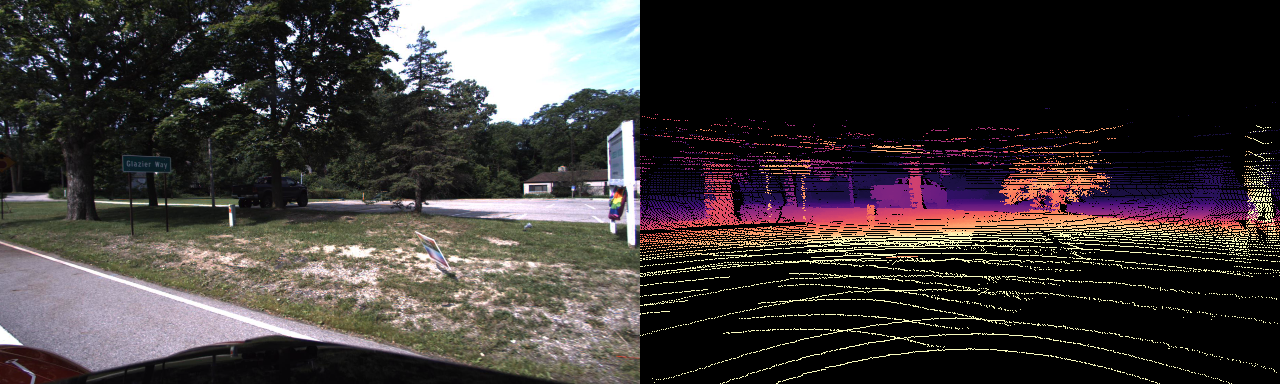

In [18]:
import matplotlib

def viz_depth(depth, background=(0, 0, 0)):
    # "depth == 0" means that there is no LiDAR point observed
    invalid = depth == 0

    inv_depth = 1. / depth.clip(1e-6, None)
    inv_depth[invalid] = 0.

    percentile = 80
    normalizer = np.percentile(inv_depth[inv_depth > 0], percentile)
    inv_depth = inv_depth / (normalizer + 1e-6)

    cmap = matplotlib.colormaps['magma']
    depth_colored = cmap(np.clip(inv_depth, 0., 1.0))[:, :, :3]
    depth_colored[invalid] = background

    return (depth_colored * 255.0).astype(np.uint8)

Image.fromarray(
    np.concatenate([image_camera['camera06'], viz_depth(depth_camera['camera06'])],axis=1)
)

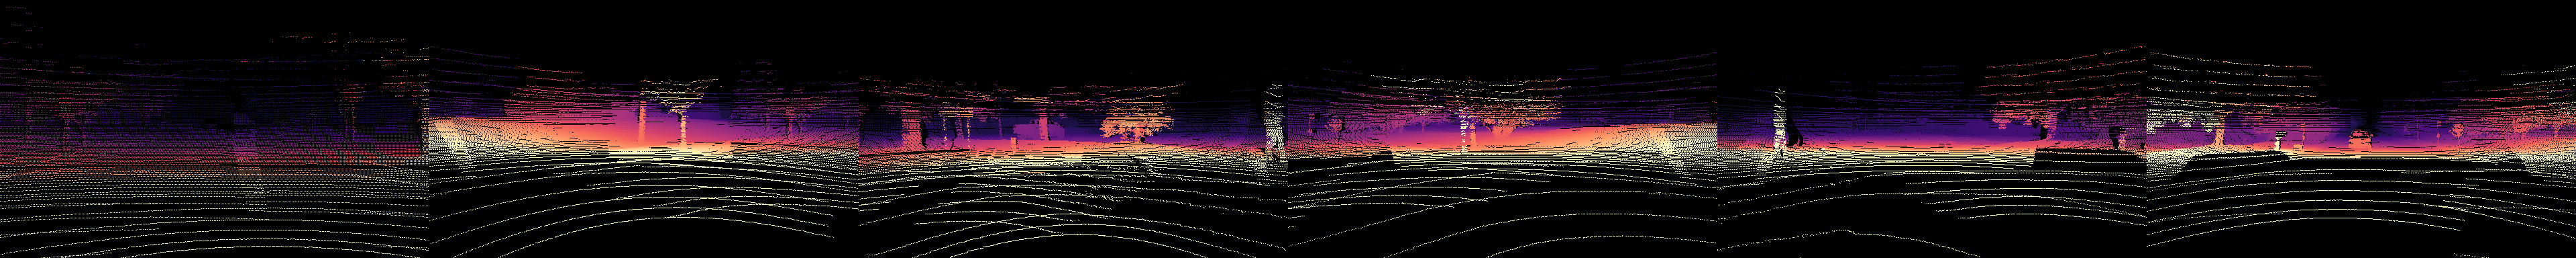

In [19]:
display(Image.fromarray(np.hstack(
    [viz_depth(depth_camera[f"camera{num:02d}"]) for num in camera_numbers]
)))


In [20]:
def get_pixel_grid(height, width, with_ones=True):
    """Create a pixel grid

    Parameters
    ----------
    height : int
        height of the grid
    width : int
        width of the grid        
    with_ones : Bool
        whether the ones are appended (homogeneous coordinate)

    Returns
    -------
    grid : np.ndarray (2 x H x W) or (3 x H x W)
        Output pixel grid
    """    
    xx, yy = np.meshgrid(
        np.linspace(0, width - 1, width),
        np.linspace(0, height - 1, height),        
        indexing='xy')    
    
    coords = [xx, yy]
    if with_ones:
        coords += [np.ones_like(xx)]
    grid = np.stack(coords, 0)
    return grid

In [21]:
def reconstruct_depth_map(depth, K, T_wc):
    """Reconstruct 3D points in world coordinate from depth map

    Parameters
    ----------
    depth : np.ndarray (H x W)
        input depth map
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_wc : np.ndarray (4 x 4)
        transformation to world coordinate from camera coordinate

    Returns
    -------
    points : np.ndarray (3 x H x W)
        output 3D points 
    """
    h, w = depth.shape
    K_inv = np.linalg.inv(K)  # (3 x 3)
    
    # Get a pixel grid (image coordinate)
    grid = get_pixel_grid(h, w, with_ones=True)
    grid = grid.reshape(3, -1)    # (3 x H x W) -> (3 x N)
        
    # Get 3D points in camera coordinate system
    #  - numpy broadcasting during element-wise multiplication
    #    : (1 x N) * (3 x N) -> (3 x N) (broadcasting) * (3 x N) -> (3 x N)
    pts3d_cam = depth.reshape(1, -1) * np.matmul(K_inv, grid)

    # Transform the coordinate, from camera to world
    pts3d_cam_homogeneous = np.concatenate([pts3d_cam, np.ones((1, h * w))], axis=0)
    pts3d_world = np.matmul(T_wc, pts3d_cam_homogeneous)
    pts3d_world = pts3d_world[:3]
    
    return pts3d_world.reshape(3, h, w)

In [22]:
import copy
import pythreejs as pjs

def visualize_3d(xyz, rgb=None, show_distance=None, size=0.03, height=960, width=1500):
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    # 거리 정보가 주어진 경우  [5,]
    if show_distance is not None:        
        dist = [show_distance] if not isinstance(show_distance, (tuple, list)) else show_distance

        angles = np.linspace(1, 360, 360 * 10)
        xx = np.array([d * np.cos(angles) for d in dist]).flatten()
        yy = np.array([d * np.sin(angles) for d in dist]).flatten()
        zz = np.zeros_like(xx)

        cc = np.zeros((len(xx), 3))
        cc[:, 0] = 1.0
        
        pts = np.concatenate([pts, np.stack([xx, yy, zz], axis=1)], axis=0)
        rgb = np.concatenate([rgb, cc], axis=0)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=3)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [23]:
T_lidar_from_camera = {}
pts3d_in_lidar_from_camera = {}
xyz3d ={}
rgb3d = {}
xyz3d_in_camera={}
T_lidar_from_camera01 = np.matmul(np.linalg.inv( T_world_from_camera['camera01']),T_world_from_lidar)
for num in camera_numbers:
    camera_id = f"camera{num:02d}"
    # 1. Reconstruct 3D points from frame 1 using depth + intrinsics + poses
    T_lidar_from_camera[camera_id] = np.matmul(np.linalg.inv(T_world_from_lidar), T_world_from_camera[camera_id])
    pts3d_in_lidar_from_camera[camera_id] = reconstruct_depth_map(depth_camera[camera_id], K_camera[camera_id], T_lidar_from_camera[camera_id])
    
    # 1-1. Visualize for debugging (should be a part of 1-2)
    xyz3d[camera_id] = pts3d_in_lidar_from_camera[camera_id].astype(np.float32)
    valid = depth_camera[camera_id] > 0

    rgb3d[camera_id] = image_camera[camera_id][valid].astype(np.float32) / 255.0
    xyz3d[camera_id] = xyz3d[camera_id][:, valid].T
    ones = np.ones((xyz3d[camera_id].shape[0], 1))
    homogeneous_points = np.hstack([xyz3d[camera_id], ones])
    xyz3d_in_camera[camera_id] = (T_lidar_from_camera01 @ homogeneous_points.T).T[:, :3]

# Image
# display(Image.fromarray(image_camera['camera06']).resize(size=(image_camera['camera06'].shape[1]//2, image_camera['camera06'].shape[0]//2)))

# Reconstructed 3D from depth map (in world coordinate system, which is the same with LiDAR coordinate system in this example)
# display(visualize_3d(xyz3d['camera08'], rgb3d['camera08'], size=0.2))


In [24]:
import numpy as np
import pythreejs as pjs
import torch
def visualize_3d_list(xyz_list, rgb_list, size=0.03, height=480, width=480):
    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointClouds = []
    for xyz, rgb in zip(xyz_list, rgb_list):
        points_buf = pjs.BufferAttribute(array=xyz)
        geometryAttrs = {'position': points_buf}

        colors_buf = pjs.BufferAttribute(array=rgb)
        geometryAttrs['color'] = colors_buf

        geometry = pjs.BufferGeometry(attributes=geometryAttrs)
        pointClouds.append(pjs.Points(geometry=geometry, material=material))

    pythreejs_camera = pjs.PerspectiveCamera(
        up=[1, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (60, -30., 60.)

    axes = pjs.AxesHelper(size=3)

    scene = pjs.Scene(children=pointClouds + [
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777'),
                    axes],
                    background = 'black')

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [25]:
# import numpy as np

# # 가정: xyz3d는 이미 각 카메라에 대해 계산된 3D 포인트를 LiDAR 좌표계로 나타내는 딕셔너리입니다.
# # T_lidar_from_camera는 LiDAR 좌표계에서 각 카메라 좌표계로 변환하는 변환 행렬을 포함하는 딕셔너리입니다.

# # 각 카메라에 대한 3D 포인트를 카메라 좌표계로 변환합니다.
# xyz3d_in_camera = {}

# for camera_id, T_lidar_to_camera in T_lidar_from_camera.items():
#     # 포인트를 동차 좌표로 변환
#     ones = np.ones((xyz3d[camera_id].shape[0], 1))
#     homogeneous_points = np.hstack([xyz3d[camera_id], ones])
    
#     # T_lidar_from_camera의 역변환을 사용하여 LiDAR 좌표계에서 카메라 좌표계로 변환
#     T_camera_from_lidar = np.linalg.inv(T_lidar_to_camera)
#     xyz3d_in_camera[camera_id] = (T_camera_from_lidar @ homogeneous_points.T).T[:, :3]

# # 이제 xyz3d_in_camera 딕셔너리에는 각 카메라 좌표계에 대한 3D 포인트가 포함되어 있습니다.


In [26]:
import numpy as np

# 각 카메라에서 얻은 점과 색상 배열을 개별적으로 더하여 단일 배열로 만듭니다.
# points_all = np.concatenate((xyz3d['camera01'], xyz3d['camera05'], xyz3d['camera06'], xyz3d['camera07'], xyz3d['camera08'], xyz3d['camera09']))
# colors_all = np.concatenate((rgb3d['camera01'], rgb3d['camera05'], rgb3d['camera06'], rgb3d['camera07'], rgb3d['camera08'], rgb3d['camera09']))

points_all = np.concatenate((xyz3d_in_camera['camera01'], xyz3d_in_camera['camera05'], xyz3d_in_camera['camera06'], xyz3d_in_camera['camera07'], xyz3d_in_camera['camera08'], xyz3d_in_camera['camera09']))
colors_all = np.concatenate((rgb3d['camera01'], rgb3d['camera05'], rgb3d['camera06'], rgb3d['camera07'], rgb3d['camera08'], rgb3d['camera09']))

# visualize_3d_list 함수를 호출하여 시각화합니다.
renderer = visualize_3d_list([points_all], [colors_all], size=0.3, height=960, width=1500)

renderer


/home/chungwoo/anaconda3/envs/ddad/lib/python3.8/site-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [27]:
points_all.shape

(227430, 3)

In [28]:
# import numpy as np

# def quaternion_to_rotation_matrix(q):
#     qw, qx, qy, qz = q['qw'], q['qx'], q['qy'], q['qz']
#     # Compute the rotation matrix from quaternion
#     R = np.array([
#         [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
#         [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
#         [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
#     ])
#     return R

# def get_translation_vector(translation):
#     T = np.array([translation['x'], translation['y'], translation['z']])
#     return T

# # 각 카메라의 회전 행렬과 변환 벡터 계산 및 출력
# rotation_matrices = {}
# translation_vectors = {}
# for camera, params in extrinsics_camera.items():
#     rotation_matrices[camera] = quaternion_to_rotation_matrix(params['rotation'])
#     translation_vectors[camera] = get_translation_vector(params['translation'])
#     print(f"{camera} - Rotation Matrix (R):\n{rotation_matrices[camera]}\n")
#     print(f"{camera} - Translation Vector (T):\n{translation_vectors[camera]}\n")




In [29]:
# import numpy as np

    
# def calculate_relative_rotation_matrices(base_rotation_matrix, rotation_matrices):
#     relative_rotations = {}
#     R_base_inv = np.linalg.inv(base_rotation_matrix)  # 기준 회전 행렬의 역행렬 계산
#     for camera, R in rotation_matrices.items():
#         R_relative = R_base_inv @ R  # 상대 회전 행렬 계산
#         angle_yaw = np.degrees(np.arctan2(R_relative[1, 0], R_relative[0, 0]))  # z 축 회전 각도 추출
#         relative_rotations[camera] = R_relative
#     return relative_rotations

# # 카메라 1을 기준으로 계산
# base_rotation_matrix = rotation_matrices['camera01']
# relative_rotations = calculate_relative_rotation_matrices(base_rotation_matrix, rotation_matrices)

# for camera, R_rel in relative_rotations.items():
#     print(f"{camera} - Relative Rotation Matrix:\n{R_rel}\n")




In [30]:
# T_camera01_to_lidar = np.linalg.inv(T_lidar_from_camera['camera01'])
# T_camera_to_camera01 = {}
# for camera_id, T_lidar_to_camera in T_lidar_from_camera.items():
#     if camera_id == 'camera01':
#         continue  # 같은 카메라에 대해서는 계산 불필요
#     # 카메라에서 라이다로의 변환 (역행렬)
#     T_camera_to_lidar = np.linalg.inv(T_lidar_to_camera)
#     # Camera01을 기준으로 하는 변환 매트릭스 계산
#     T_camera_to_camera01[camera_id] = np.dot(T_camera01_to_lidar, T_camera_to_lidar)



- 

In [31]:

# import numpy as np

# # 정의된 변환 함수
# def inverse_transformation(R, T):
#     R_inv = R.T  # Transpose of rotation matrix is its inverse for orthogonal matrices
#     T_inv = -R_inv @ T  # Compute inverse translation
#     return R_inv, T_inv

# # 라이다 좌표계에서 카메라 좌표계로의 변환 매트릭스
# def lidar_to_camera_matrix():
#     R_lidar_to_camera = np.array([[0, 0, 1],
#                                   [-1, 0, 0],
#                                   [0, -1, 0]])
#     return R_lidar_to_camera

# R_camera01, T_camera01 = rotation_matrices['camera01'], translation_vectors['camera01']
# R_lidar_to_camera = lidar_to_camera_matrix()
# R_inv_camera01, T_inv_camera01 = inverse_transformation(R_camera01, T_camera01)

# relative_rotations = {}
# relative_translations = {}

# # 모든 카메라를 포함하도록 반복문 수정
# for camera in extrinsics_camera.keys():
#     R_source, T_source = rotation_matrices[camera], translation_vectors[camera]
    
#     # 라이다 좌표계에서 카메라 좌표계로 변환된 회전 매트릭스 적용
#     R_lidar_adjusted = R_source @ R_lidar_to_camera
    
#     # Compute the relative rotation and translation
#     R_relative = R_lidar_adjusted @ R_inv_camera01
#     T_relative = R_lidar_adjusted @ T_inv_camera01 + T_source

#     relative_rotations[camera] = R_relative
#     relative_translations[camera] = T_relative

# # 모든 카메라의 상대적 회전과 변환 출력
# print("Relative Rotations:")
# for camera, R in relative_rotations.items():
#     print(f"{camera}:\n{R}\n")

# print("Relative Translations:")
# for camera, T in relative_translations.items():
#     print(f"{camera}:\n{T}\n")


In [32]:
# def transform_points_to_camera01(points, transformation_matrix):
#    # 포인트들을 동차 좌표계로 변환
#    homogeneous_points = np.hstack([points, np.ones((points.shape[0], 1))])
#    # 변환 적용
#    transformed_points = transformation_matrix @ homogeneous_points.T
#    return transformed_points[:3].T  # 동차 좌표 제거

# # 각 카메라의 포인트를 Camera01 좌표계로 변환
# xyz3d_in_camera01_coords = {}
# for camera, points in xyz3d_in_camera.items():
#    if camera == 'camera01':
#        xyz3d_in_camera01_coords[camera] = points  # 이미 Camera01 좌표계 내
#    else:
#        xyz3d_in_camera01_coords[camera] = transform_points_to_camera01(points, T_camera_to_camera01_base[camera])

# # 모든 카메라 데이터를 하나의 배열로 결합
# camera_point = np.concatenate([xyz3d_in_camera01_coords[camera] for camera in sorted(xyz3d_in_camera01_coords)])


In [33]:
# def transform_points_to_camera01(xyz_points, camera, relative_rotations):
#     R = relative_rotations[camera]
#     # Apply the transformation to the points
#     xyz_transformed = R @ xyz_points.T
#     return xyz_transformed.T

# # 각 카메라의 포인트를 camera01 좌표계로 변환
# xyz3d_in_camera01_coords = {}

# for camera, points in xyz3d_in_camera.items():
#     xyz_transformed = transform_points_to_camera01(points, camera, relative_rotations)
#     xyz3d_in_camera01_coords[camera] = xyz_transformed

# camera_point = np.concatenate((xyz3d_in_camera01_coords['camera01'], xyz3d_in_camera01_coords['camera05'], xyz3d_in_camera01_coords['camera06'], xyz3d_in_camera01_coords['camera07'], xyz3d_in_camera01_coords['camera08'], xyz3d_in_camera01_coords['camera09']))

In [34]:
# renderer = visualize_3d_list([camera_point], [colors_all], size=0.3, height=960, width=1500)
# renderer


In [35]:
def T_orthogonal_to_cylindrical(points):
    r = np.sqrt((points[:,2])**2 + (points[:,0])**2)
    angle = np.arctan2(points[:,0], points[:,2])
    height = points[:,1]/r
    return r, angle, height

In [36]:
print(points_all[:,1])

[-9.3195 -9.3264 -9.3228 ...  1.4806  1.4873  1.4797]


In [37]:
# r={}
# angle ={}
# height={}
# for num in camera_numbers:
#     camera_id = f"camera{num:02d}"
#     r[camera_id],angle[camera_id],height[camera_id] = T_orthogonal_to_cylindrical(xyz3d_in_camera[camera_id])
    

r,angle,height = T_orthogonal_to_cylindrical(points_all)

In [38]:
# # 각 카메라에서 얻은 점과 색상 배열을 개별적으로 더하여 단일 배열로 만듭니다.
# r_all = np.concatenate((r['camera01'], r['camera05'], r['camera06'], r['camera07'], r['camera08'], r['camera09']))
# angle_all = np.concatenate((angle['camera01'], angle['camera05'], angle['camera06'], angle['camera07'], angle['camera08'], angle['camera09']))
# z_all = np.concatenate((height['camera01'], height['camera05'], height['camera06'], height['camera07'], height['camera08'], height['camera09']))
# r_all = torch.tensor(r['camera05'])
# angle_all = torch.tensor(angle['camera05'])
# z_all = torch.tensor(height['camera05'])

In [39]:
# print(min(angle['camera01']),max((angle['camera01'])))
# print(min(angle['camera05']),max((angle['camera05'])))
# print(min(angle['camera06']),max((angle['camera06'])))
# print(min(angle['camera07']),max((angle['camera07'])))
# print(min(angle['camera08']),max((angle['camera08'])))
# print(min(angle['camera09']),max((angle['camera09'])))

# ac1 = (min(angle['camera01'])+max((angle['camera01'])))/2
# ac6 = (min(angle['camera05'])+max((angle['camera05'])))/2
# ac8 = (min(angle['camera06'])+max((angle['camera06'])))/2
# ac9 = (min(angle['camera07'])+max((angle['camera07'])))/2
# ac7 = (min(angle['camera08'])+max((angle['camera08'])))/2
# ac5 = (min(angle['camera09'])+max((angle['camera09'])))/2
# ac15 = ac5-ac1
# ac17 = ac7-ac1
# ac19 = ac9-ac1
# ac16 = ac6-ac1
# ac18 = ac8-ac1
# print(ac19)


In [40]:

# r_theta_z = torch.stack([r_all,angle_all,z_all]).T
# print(r_theta_z)

r = torch.tensor(r)
angle = torch.tensor(angle)
height = torch.tensor(height)
r_theta_z = torch.stack([r,angle,height]).T
print(r_theta_z)


tensor([[37.6467, -0.3916, -0.2476],
        [37.6378, -0.3892, -0.2478],
        [37.5684, -0.3857, -0.2482],
        ...,
        [ 4.1362, -2.7820,  0.3580],
        [ 4.1584, -2.7746,  0.3577],
        [ 4.1496, -2.7703,  0.3566]], dtype=torch.float64)


In [41]:
import torch
import numpy as np

def create_depth_map(cylindrical_coords, image_width, image_height):
    # θ를 이미지의 너비에 맞게 조정
    
    # z 값을 이미지 높이에 맞게 조정
    phi_min = -np.pi
    phi_max = np.pi
    z_min = -0.2
    z_max = 0.2

    # Normalizing theta and z to image coordinates
    theta_normalized = ((cylindrical_coords[:, 1] - phi_min) / (phi_max - phi_min)) * (image_width - 1)
    z_normalized = ((cylindrical_coords[:, 2] - z_min) / (z_max - z_min)) * (image_height - 1)

    # Initialize the depth map with zeros
    depth_map = np.zeros((image_height, image_width))

    
    # 데이터 타입을 정수로 변환
    theta_normalized = theta_normalized.to(torch.int).numpy()
    z_normalized = z_normalized.to(torch.int).numpy()
    
    for i, (theta, z) in enumerate(zip(theta_normalized, z_normalized)):
        if 0 <= z < image_height and 0 <= theta < image_width:
            depth_map[z, theta] = cylindrical_coords[i, 0].item()

    return depth_map

In [42]:
depth_map = create_depth_map(r_theta_z, image_width=2048, image_height=256)
print(depth_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


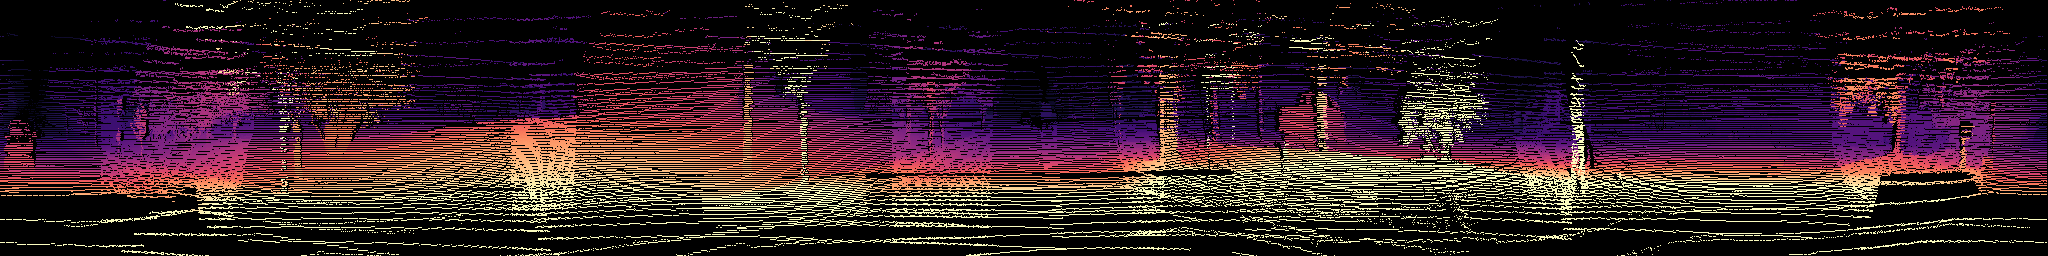

In [43]:
display(Image.fromarray(np.hstack(
    [viz_depth(depth_map)]
)))

In [44]:
def visualize_cylinder(r_all,angle_all,z_all, rgb=None, show_distance=None, size=0.03, height=960, width=1500):
    xx = 1 * np.cos(angle_all)
    yy = 1 * np.sin(angle_all)
    zz = z_all
    xyz = np.stack([xx, yy, zz], axis=1)
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-5., 0., 5.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=1)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [45]:
display(visualize_cylinder(r,angle, -height, colors_all, size=0.01))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [46]:
def unfold_cylinder(r_all,angle_all,z_all, rgb=None, show_distance=None, size=0.01, height=960, width=1500):
    
    yy = angle_all
    xx = np.ones_like(yy)
    zz = z_all
    xyz = np.stack([xx, yy, zz], axis=1)
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-5., 0., 5.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=1)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [47]:
# unfold_cylinder(angle_all,z_all,colors_all)
unfold_cylinder(r,angle,-height,colors_all)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…